In [11]:
import os
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

data = pd.read_csv('data.csv')
data.head()

Molecule  A:63:HBond  A:66:HBond  A:115:Hydrophobic  A:123:Hydrophobic  \
0   Compound_1      0.9811      2.1964             0.3330             0.5083   
1   Compound_1      0.9922      2.2209             0.4040             0.4750   
2   Compound_1      0.9834      2.3541             0.3807             0.4861   
3  Compound_10      0.9889      2.3729             0.3940             0.4695   
4  Compound_10      0.9922      2.3352             0.4428             0.4606   

   A:56:Hydrophobic  A:68:Hydrophobic  A:113:Pi-Cation  A:56:Pi-Pi  \
0            0.6182            0.3463           0.6959      0.5083   
1            0.6604            0.5083           0.8213      0.4828   
2            0.5816            0.5017           0.9145      0.5150   
3            0.6038            0.3885           0.8946      0.4295   
4            0.6515            0.3074           0.9256      0.3685   

   A:58:WaterBridge  ...  A:78:HBond  A:170:WaterBridge  A:171:WaterBridge  \
0            0.5738  ...         0.0                0.0                0.0   
1            0.4806  ...         0.0                0.0                0.0   
2            0.5050  ...         0.0                0.0                0.0   
3            0.5028  ...         0.0                0.0                0.0   
4            0.4495  ...         0.0                0.0                0.0   

   A:75:WaterBridge  A:76:HBond  A:56:HBond  A:212:WaterBridge  \
0               0.0         0.0         0.0                0.0   
1               0.0         0.0         0.0                0.0   
2               0.0         0.0         0.0                0.0   
3               0.0         0.0         0.0                0.0   
4               0.0         0.0         0.0                0.0   

   A:217:WaterBridge  Strain_perHeavyAtom     pIC50  
0                0.0               0.0721  8.045757  
1                0.0               0.0721  8.045757  
2                0.0               0.0721  8.045757  
3                0.0               0.0843  7.795880  
4                0.0               0.0843  7.795880  

[5 rows x 45 columns]

In [103]:
def load_json(path):
    with open(path) as file:
        data = json.load(file)
    return data

def load_results(path):
    imp = pd.read_csv(os.path.join(path, 'importance.csv'), index_col=0)
    cv = load_json(os.path.join(path, 'cross_validation.json'))
    
    # LOO-CV Results
    df = pd.DataFrame()
    df['ID'] = cv['ids']
    df['pred'] = cv['pred']
    df['obs'] = cv['obs']
    
    # LOO-CV Importances
    cv_imp = pd.DataFrame(cv['imp']).T
    cv_imp.columns = [f'fold{i}' for i in range(cv_imp.shape[1])]
    
    
    return df, imp, cv_imp


## LASSO

In [104]:
df, imp, cv_imp = load_results('data_lasso')
top10 = imp.loc[imp.importance.abs().sort_values(ascending=False).index.values].iloc[:10]
top10

importance
Strain_perHeavyAtom   -9.086515
A:63:WaterBridge      -2.373303
A:123:Pi-Pi           -1.523325
A:76:WaterBridge       1.086264
A:123:Hydrophobic      0.895869
A:56:Hydrophobic      -0.835396
A:115:Hydrophobic      0.813824
A:68:Hydrophobic      -0.558635
A:117:WaterBridge      0.535562
A:73:HBond            -0.500514

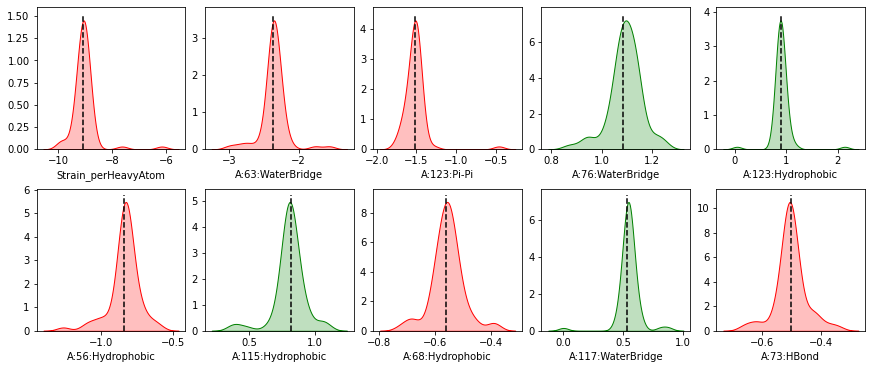

In [93]:
fig, axs = plt.subplots(2,5,figsize=(12,5), constrained_layout=True)

for ax, feature in zip(axs.flatten(), top10.index.values):
    color = 'green'
    if top10.loc[feature]['importance'] < 0:
        color = 'red'
    sns.kdeplot(cv_imp.loc[feature], ax=ax, fill=True, color=color)
    ax.set_ylabel(None)
    ax.plot([top10.loc[feature]['importance']]*2, [0, ax.dataLim._points[1,1] * 1.05], '--', color='black')

plt.savefig('data_lasso/weight_distributions.svg', format='svg', bbox_inches='tight', dpi=1200)
plt.show()

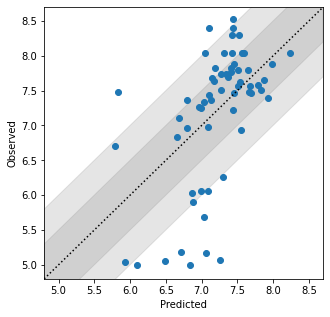

In [97]:
mean = df.groupby('ID').mean()
mean['abs_err'] = (mean.pred - mean.obs).abs()

llim = 4.8
ulim = 8.7


fig = plt.figure(figsize=(5,5))

plt.fill_between([llim, ulim], [llim-0.5, ulim-0.5], [llim+0.5, ulim+0.5], color='gray', alpha=0.2)
plt.fill_between([llim, ulim], [llim-1, ulim-1], [llim+1, ulim+1], color='gray', alpha=0.2)
plt.plot([llim, ulim], [llim, ulim], ':', color='black')
plt.scatter(mean.pred, mean.obs)
plt.xlim([llim, ulim])
plt.ylim([llim, ulim])
plt.xlabel('Predicted')
plt.ylabel('Observed')

plt.savefig('data_lasso/lomocv_parity.svg', format='svg', bbox_inches='tight', dpi=1200)
plt.show()

In [102]:
def error_rate(err):
    n = (mean['abs_err'] < err).sum()
    return n / len(mean)

for err in [0.5, 1.0]:
    rate = error_rate(err)
    print(f'{rate * 100}% of predictions were within the +/-{err} interval')

54.09836065573771% of predictions were within the +/-0.5 interval
78.68852459016394% of predictions were within the +/-1.0 interval


## Gradient Boosting (Mean)

In [105]:
df, imp, cv_imp = load_results('data_mean_gradient_boosting')
top10 = imp.loc[imp.importance.abs().sort_values(ascending=False).index.values].iloc[:10]
top10

importance
A:123:Hydrophobic      0.282106
Strain_perHeavyAtom    0.263187
A:66:HBond             0.164611
A:56:Hydrophobic       0.100603
A:68:Hydrophobic       0.050546
A:73:HBond             0.030331
A:66:WaterBridge       0.023424
A:63:HBond             0.021459
A:115:Hydrophobic      0.016465
A:73:WaterBridge       0.012749

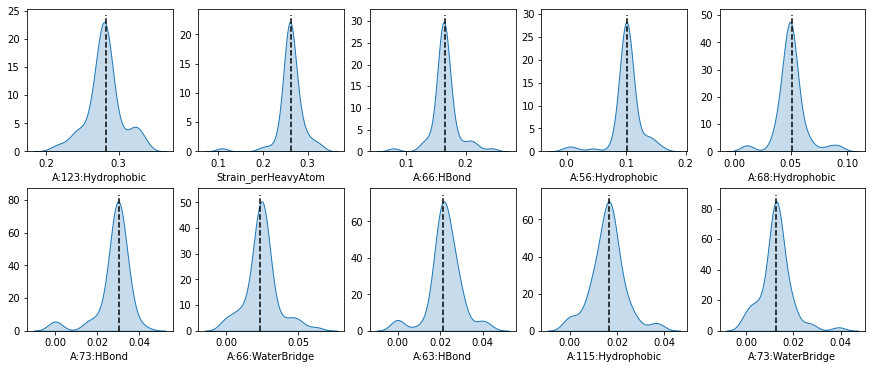

In [107]:
fig, axs = plt.subplots(2,5,figsize=(12,5), constrained_layout=True)

for ax, feature in zip(axs.flatten(), top10.index.values):
    sns.kdeplot(cv_imp.loc[feature], ax=ax, fill=True)
    ax.set_ylabel(None)
    ax.plot([top10.loc[feature]['importance']]*2, [0, ax.dataLim._points[1,1] * 1.05], '--', color='black')

plt.savefig('data_mean_gradient_boosting/weight_distributions.svg', format='svg', bbox_inches='tight', dpi=1200)
plt.show()

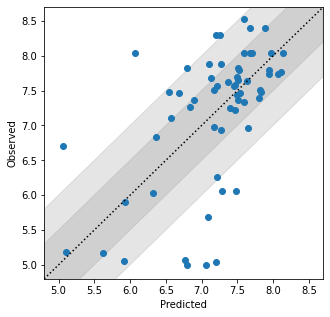

In [108]:
mean = df.groupby('ID').mean()
mean['abs_err'] = (mean.pred - mean.obs).abs()

llim = 4.8
ulim = 8.7

fig = plt.figure(figsize=(5,5))

plt.fill_between([llim, ulim], [llim-0.5, ulim-0.5], [llim+0.5, ulim+0.5], color='gray', alpha=0.2)
plt.fill_between([llim, ulim], [llim-1, ulim-1], [llim+1, ulim+1], color='gray', alpha=0.2)
plt.plot([llim, ulim], [llim, ulim], ':', color='black')
plt.scatter(mean.pred, mean.obs)
plt.xlim([llim, ulim])
plt.ylim([llim, ulim])
plt.xlabel('Predicted')
plt.ylabel('Observed')

plt.savefig('data_mean_gradient_boosting/lomocv_parity.svg', format='svg', bbox_inches='tight', dpi=1200)
plt.show()

In [109]:
def error_rate(err):
    n = (mean['abs_err'] < err).sum()
    return n / len(mean)

for err in [0.5, 1.0]:
    rate = error_rate(err)
    print(f'{rate * 100}% of predictions were within the +/-{err} interval')

60.65573770491803% of predictions were within the +/-0.5 interval
80.32786885245902% of predictions were within the +/-1.0 interval
